<a href="https://colab.research.google.com/github/conichito/AS3201/blob/main/Tarea%202/Tarea_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importamos librerias relevantes

from astropy.io import fits
import matplotlib.pyplot as plt #module for plotting
import numpy as np #this module is for working with arrays like in matlab
import scipy as sp
from scipy import ndimage
from scipy.optimize import curve_fit
import pandas as pd
import astropy.units as u
import astropy.constants as c

# Ignoramos warnings

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Constantes a usar

R0 = 8.5   # kpc
vsun = 220 # km/s
w0 = vsun/R0
G = c.G.to(u.kpc*u.km**2/u.Msun/u.s**2) # kpc*km**2/Msun/s**2

In [3]:
# Cargamos datos

cube = fits.open(r"/content/drive/MyDrive/southgal_fixbadc.fits") #open data cube object
data = cube[0].data #extract data matrix
header = cube[0].header #extract the header from the fits file

In [4]:
# Vemos datos
header, data.shape#()

(SIMPLE  =                    T  / Standard FITS format                          
 BITPIX  =                  -32 / Bits per pixel                                 
 NAXIS   =                    3  / Number of axes                                
 NAXIS1  =                  306  / Number pixels on axis 1                       
 NAXIS2  =                  385  / Number pixels on axis 2                       
 NAXIS3  =                   33  / Number pixels on axis 3                       
 CTYPE1  = 'VELO-LSR'            / axis 1 coord type                             
 CRVAL1  =        -2.307985E+02 / coord value at CRPIX1                          
 CDELT1  =         1.300400E+00 / pixel spacing for axis 1                       
 CRPIX1  =             1.000000  / ref pixel for axis 1                          
 CTYPE2  = 'GLON-FLT'            / axis 2 coord type                             
 CRVAL2  =         3.000000E+02 / coord value at CRPIX2                          
 CDELT2  =      

In [5]:
# Para facilitar el uso de los datos creamos una función que entregue los valores de los ejes

def values(h, j):
    N = h['NAXIS' + str(j)]
    val = np.zeros(N)
    for i in range(0, N):
        val[i] = (i + 1 - float(h['CRPIX' + str(j)])) * float(h['CDELT' + str(j)]) + float(h['CRVAL' + str(j)])
    return val

# Definimos variables

vel = values(header, 1)
lon = values(header, 2)
lat = values(header, 3)

#P2

In [6]:
# Constantes a usar

R0 = 8.5   # kpc
vsun = 220 # km/s
w0 = vsun/R0

# Definimos una función que encuentra y guarda la primera velocidad que cumple las restricciones de ruido para cada punto

def fmin(l, latitude, velocity, vs):
    #   Iteramos sobre la latitud
        for b in range(len(latitude)):
    #       Vemos las velocidades de un (b, l)
            T1 = data[b][l][:]
            rms = np.sqrt(np.mean(T1**2))   # Calculo de RMS de ese array de vel
    #       Iteraciones sobre la velocidad
            for v in range(len(velocity)):
                if data[b][l][v] >= 5 * rms:  # Condicional para filtrar ruido
                    vs[b] = velocity[v]    # Se guarda la primera velocidad que no sea ruido
                    break

In [7]:
# Definimos una función que tome la longitud de los puntos y encuentre y guarde su velocidad negativa minima (mayor magnitud) junto con su latitude asociada, además forma un array para R.

def maximorums(longitude, latitude, velocity):
    n_l = len(longitude)
    n_b = len(latitude)
    vmin = np.zeros(n_l)  # Creamos los arrays de zeros que se modificarán después
    bvmin = np.zeros(n_l)
    R = np.zeros(n_l)
    Z = np.zeros(n_l)
    for i in range(n_l): # vamos sobre las longitudes
        vs = np.zeros(n_b)
        fmin(i, latitude, velocity, vs) # para conseguir el array de minimos para la latitud actual
        v1 = vs[0]          # Seteamos los primeros valoresde v y b
        b1 = latitude[0]
        for j in range(n_b - 1): # iteramos spobre la latitud
            if vs[j + 1] < v1:  # se actualizan si se encuentra uno menor
                v1 = vs[j + 1]
                b1 = latitude[j + 1]
        vmin[i] = v1    # una vez se itera sobre toda una latitud para una longitud,
        bvmin[i] = b1   # se guarda el maximorum y el v minimo correspondiente
        R[i] = np.abs(R0 * np.sin(np.radians(longitude[i])))
        Z[i] = np.radians(b1) * R0 * np.cos(np.radians(longitude[i]))

    return vmin, bvmin, R, Z


In [8]:
# Finalmente, definimos una función que en entregue los valores de V(R)

def vr(longitude, vmin):
    n_l = len(longitude)
    l_rad = np.radians(longitude)
    vR = np.zeros(n_l)
    for l in range(n_l): # Para cada longitud, una velocidad de rotación relacionada a esta
        vR[l] = vmin[l] * (np.abs(np.sin(l_rad[l]))) / np.sin(l_rad[l]) + np.abs(vsun * np.sin(l_rad[l]))

    return vR

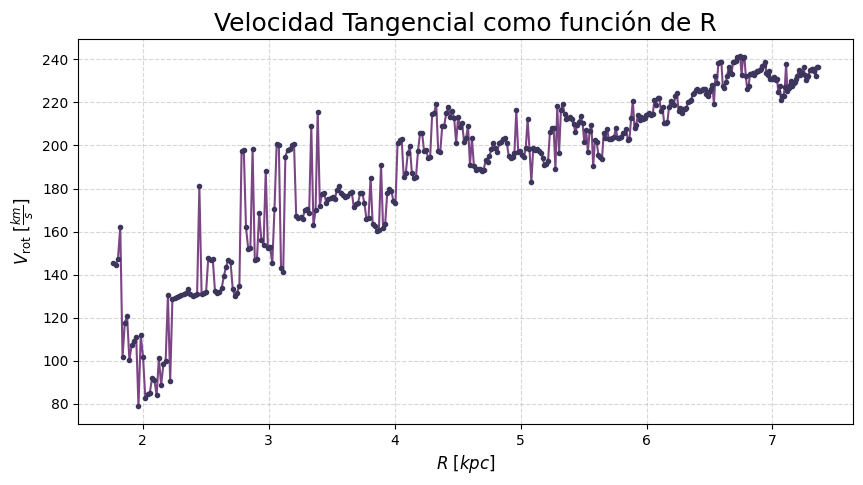

In [9]:
# Con las funciones definidas podemos proceder a graficar la curva de rotación

# Partimos con V_rot vs R

vmin, bvmin, R, _ = maximorums(lon, lat, vel)

vR = vr(lon, vmin)

plt.figure(figsize=(10, 5))
plt.plot(R, vR, color = '#7C4585')
plt.plot(R, vR, linestyle = 'None', marker = '.', color = '#3D365C')
plt.grid
plt.title("Velocidad Tangencial como función de R", fontsize=18)
plt.xlabel("$R$ $[kpc]$", fontsize=12)
plt.ylabel(r"$V_{\mathrm{rot}}$ $[\frac{km}{s}]$", fontsize=12)
plt.grid(alpha=0.5, ls = '--')

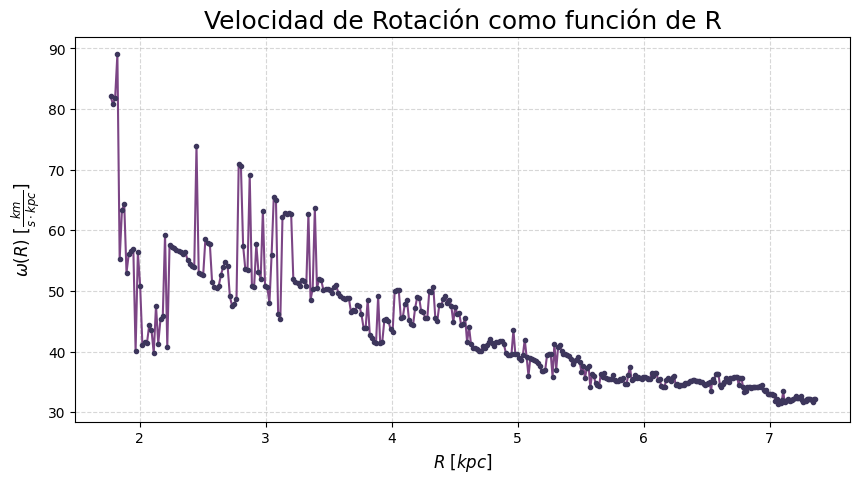

In [10]:
# Seguimos con ω(R) vs. R

def wr(vr, longitude):
    b_rad = np.radians(longitude)
    wR = vr / (R0 * np.abs(np.sin(b_rad))) # despeje simple de la ecuación de arriba
    return wR

wR = wr(vR, lon)

plt.figure(figsize=(10, 5))
plt.plot(R, wR, color = '#7C4585')
plt.plot(R, wR, linestyle = 'None', marker = '.', color = '#3D365C')
plt.grid
plt.title("Velocidad de Rotación como función de R", fontsize=18)
plt.xlabel("$R$ $[kpc]$", fontsize=12)
plt.ylabel(r"$\omega(R)$ $[\frac{km}{s \cdot kpc}]$", fontsize=12)
plt.grid(alpha=0.5, ls = '--')

#P3

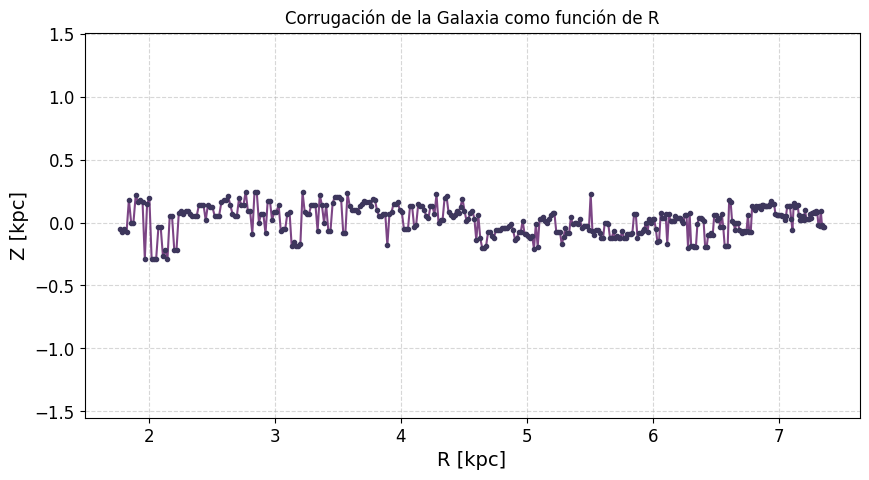

In [11]:
# Gracias a la función maximorums ya tenemos ya tenemos un array para Z, por lo que ya podemos graficar Z(R) vs R

_, _, _, Z = maximorums(lon, lat, vel)

plt.figure(figsize=(10, 5))
plt.plot(R, Z, color = '#7C4585')
plt.plot(R, Z, linestyle = 'None', marker = '.', color = '#3D365C')
plt.title("Corrugación de la Galaxia como función de R")
plt.xlabel("R [kpc]", fontsize='14')
plt.ylabel("Z [kpc]", fontsize='14')
plt.tick_params(labelsize='12')
plt.grid(alpha=0.5, ls = '--')
plt.axis('equal')
plt.show()

#P4

In [12]:
# Definimos funciones para distintos modelos de masa

# Masa puntual

def masapuntual(R, M0):
    M = M0
    v = np.sqrt(G.value * M / R) # km/s
    return v

# Disco uniforme

def disco(R, S):
    M = np.pi * (R**2) * S
    v = np.sqrt(G.value * M / R) # km/s
    return v

# Esfera uniforme

def esfera(R, rho):
    M = (4/3) * np.pi * (R**3) * rho
    v = np.sqrt(G.value * M / R) # km/s
    return v

# Masa puntual + Esfera uniforme

def disco_masa(R, S, M0):
    M = np.pi * (R**2) * S + M0
    v = np.sqrt(G.value * M / R) # km/s
    return v

# Masa puntual + Disco uniforme

def esfera_masa(R, rho, M0):
    M = (4/3) * np.pi * (R**3) * rho + M0
    v = np.sqrt(G.value * M / R) # km/s
    return v

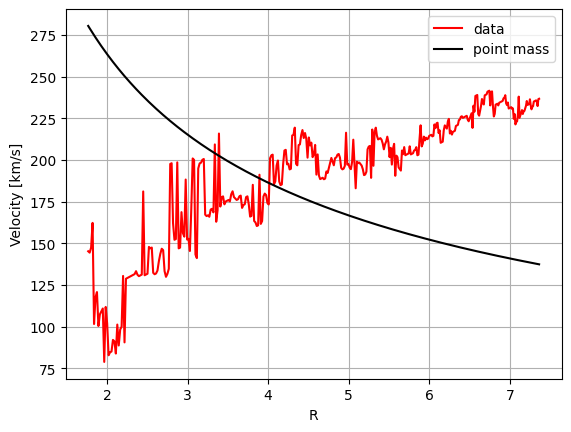

In [13]:
# Buscamos comparar los modelos de masa con los distintos perfiles de curva de rotación calculados anteriormente

# Gráfico para masa puntual

mpuntual, covmpuntual = curve_fit(masapuntual, R, vR)

plt.plot(R, vR, 'red', label='data')
plt.plot(R, masapuntual(R, mpuntual[0]), 'k', label='point mass')
plt.xlabel('R')
plt.ylabel('Velocity [km/s]')
plt.grid()
plt.legend()
plt.show()

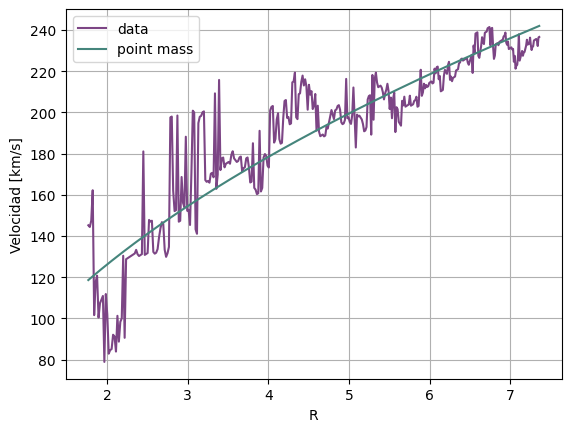

In [14]:
# Gráfico para disco uniforme

disk, covdisk = curve_fit(disco, R, vR)

plt.plot(R, vR, '#7C4585', label='data')
plt.plot(R, disco(R, disk[0]), '#45857c', label='point mass')
plt.xlabel('R')
plt.ylabel('Velocidad [km/s]')
plt.grid()
plt.legend()
plt.show()

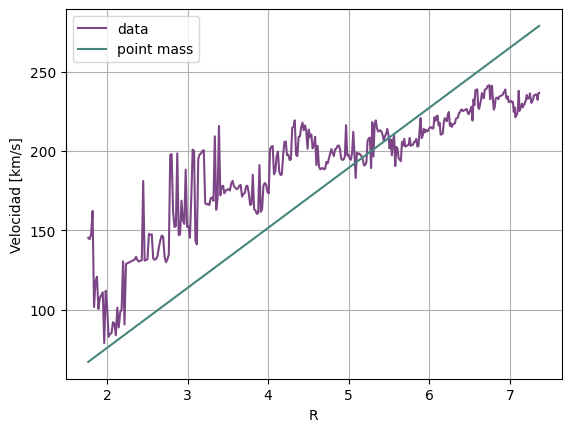

In [15]:
# Gráfico para esfera uniforme

sphere, covsphere = curve_fit(esfera, R, vR)

plt.plot(R, vR, '#7C4585', label='data')
plt.plot(R, esfera(R, sphere[0]), '#45857c', label='point mass')
plt.xlabel('R')
plt.ylabel('Velocidad [km/s]')
plt.grid()
plt.legend()
plt.show()

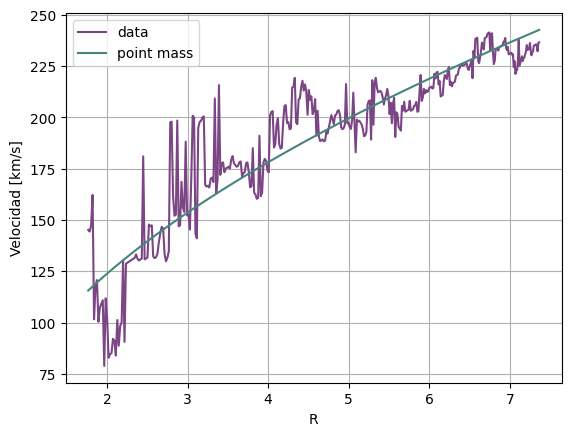

In [16]:
# Gráfico para masa puntual + esfera uniforme

disk_m, covdisk_m = curve_fit(disco_masa, R, vR)

plt.plot(R, vR, '#7C4585', label='data')
plt.plot(R, disco_masa(R, disk_m[0], disk_m[1]), '#45857c', label='point mass')
plt.xlabel('R')
plt.ylabel('Velocidad [km/s]')
plt.grid()
plt.legend()
plt.show()

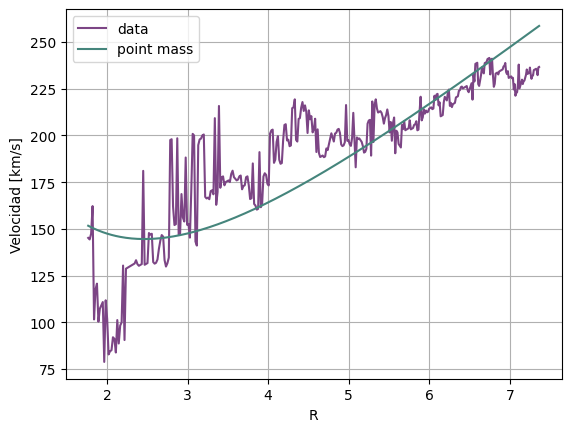

In [17]:
# Gráfico para masa puntual + disco uniforme

sphere_m, covsphere_m = curve_fit(esfera_masa, R, vR)

plt.plot(R, vR, '#7C4585', label='data')
plt.plot(R, esfera_masa(R, sphere_m[0], sphere_m[1]), '#45857c', label='point mass')
plt.xlabel('R')
plt.ylabel('Velocidad [km/s]')
plt.grid()
plt.legend()
plt.show()